# Assignment 1: Exploring Word Vectors (23 Points)

### Estimated Time: ~3 hours

The objective of this assignment is to warm-up you of some python coding, and also get you to familarize with some NLP concepts.  

In [1]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

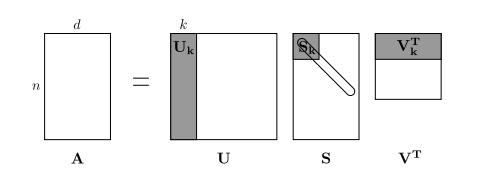

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


In [5]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

Let's have a look what these documents are like….

In [6]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [7]:
type(reuters_corpus)

list

In [8]:
len(reuters_corpus)

578

In [9]:
len(reuters_corpus[0])

209

In [10]:
for i in range(5):
  print(len(reuters_corpus[i]))

209
1001
225
240
350


### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

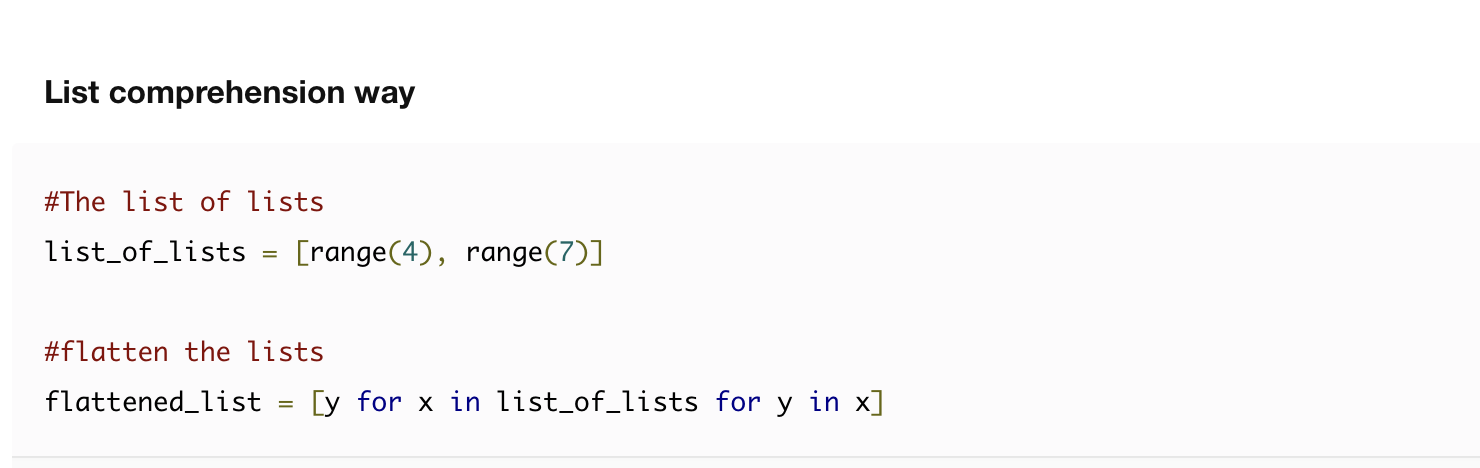

In [11]:
list1 = [range(5), range(16,20)]

In [12]:
[y for i in list1 for y in i]

[0, 1, 2, 3, 4, 16, 17, 18, 19]

In [13]:
len(set([word for wordlist in reuters_corpus for word in wordlist]))

8185

In [14]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here..
    
    corpus_words = sorted(list(set([word for wordlist in corpus for word in wordlist])))
    num_corpus_words = len(corpus_words)
    
    
    # ------------------

    return corpus_words, num_corpus_words

In [15]:
["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]

[['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'],
 ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']]

In [16]:
distinct_words([['i', 'don','know'], ['hey', 'how']])

(['don', 'hey', 'how', 'i', 'know'], 5)

In [17]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [18]:
words, num_words = distinct_words(test_corpus)
word2ind = {}
print(words[:5])
print(num_words)

for num in range(num_words):
    word2ind[words[num]] = num

print(word2ind)

['<END>', '<START>', 'All', "All's", 'ends']
10
{'<END>': 0, '<START>': 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}


In [19]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    

    for i in range(num_words):
        word2ind[words[i]] = i
    M = np.zeros((num_words, num_words))
    for line in corpus:
        for i in range(len(line)):
            target = line[i]
            target_index = word2ind[target]
            
            left = max(i - window_size, 0)
            right = min(i + window_size, len(line) - 1)
            for j in range(left, i):
                window_word = line[j]
                M[target_index][word2ind[window_word]] += 1
                M[word2ind[window_word]][target_index] += 1

    # ------------------

    return M, word2ind

In [20]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [21]:
word2ind_test

{'<END>': 0,
 '<START>': 1,
 'All': 2,
 "All's": 3,
 'ends': 4,
 'glitters': 5,
 'gold': 6,
 "isn't": 7,
 'that': 8,
 'well': 9}

In [22]:
M_test

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.]])

### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [23]:
from sklearn import decomposition

In [24]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    

    svd = decomposition.TruncatedSVD(n_components= k, n_iter= n_iters)
    M_reduced = svd.fit_transform(M)
    print(f"The original size of  embedded matrix is {M.shape}")
    print(f"The reduced size of embedded matrix is {M_reduced.shape}")
    

    # ------------------

    print("Done.")
    return M_reduced

In [25]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
The original size of  embedded matrix is (10, 10)
The reduced size of embedded matrix is (10, 2)
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [26]:
M_test_reduced

array([[ 6.54802087e-01,  7.83221122e-01],
       [ 5.20200324e-01, -4.44089210e-16],
       [ 7.05647176e-01, -4.84057274e-01],
       [ 7.05647176e-01,  4.84057274e-01],
       [ 1.02780472e+00,  0.00000000e+00],
       [ 6.54802087e-01, -7.83221122e-01],
       [ 3.82258491e-01, -6.56224003e-01],
       [ 3.82258491e-01,  6.56224003e-01],
       [ 1.39420808e+00,  1.06179274e+00],
       [ 1.39420808e+00, -1.06179274e+00]])

### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

In [27]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.

    # plt.scatter(M_reduced[:, 0], M_reduced[:, 1], c = 'olive', marker = 'x')
    plt.figure(figsize=(8,5))
    distance = 0.001
    for i, word in enumerate(words):
        coordinate = M_reduced[word2ind[words[i]], :] 

        print(f" the word {word} lies at {coordinate}")

        plt.scatter(coordinate[0], coordinate[1], c = 'olive', marker = 'x')
        plt.text(coordinate[0] + distance , coordinate[1] + distance, word)

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
 the word test1 lies at [1 1]
 the word test2 lies at [-1 -1]
 the word test3 lies at [ 1 -1]
 the word test4 lies at [-1  1]
 the word test5 lies at [0 0]
--------------------------------------------------------------------------------


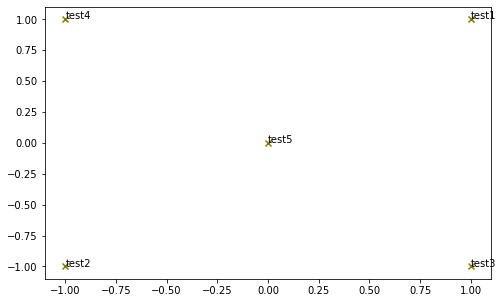

In [28]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

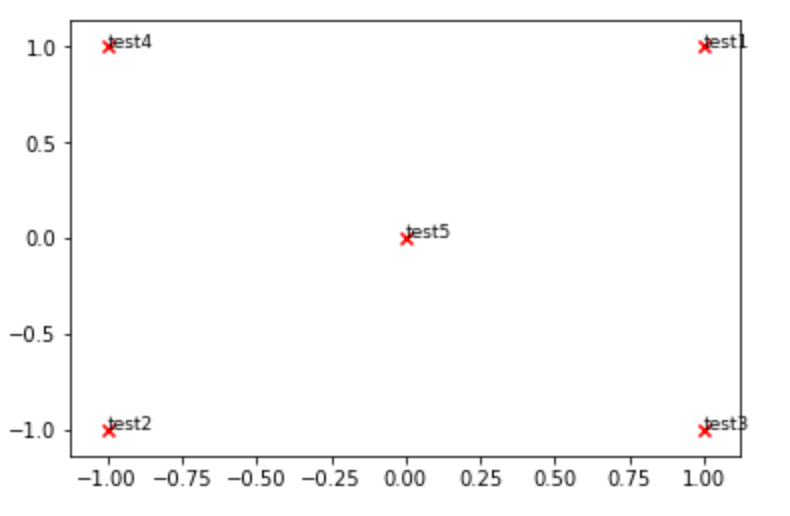


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
The original size of  embedded matrix is (8185, 8185)
The reduced size of embedded matrix is (8185, 2)
Done.
 the word barrels lies at [ 0.97614032 -0.2171407 ]
 the word bpd lies at [ 0.95680174 -0.29074118]
 the word ecuador lies at [ 0.99578754 -0.09169068]
 the word energy lies at [ 0.99996827 -0.00796552]
 the word industry lies at [0.998579   0.05329144]
 the word kuwait lies at [ 0.99340325 -0.11467337]
 the word oil lies at [ 0.99884609 -0.04802582]
 the word output lies at [ 0.98371143 -0.1797549 ]
 the word petroleum lies at [0.99714793 0.0754719 ]
 the word iraq lies at [ 0.99671621 -0.08097401]


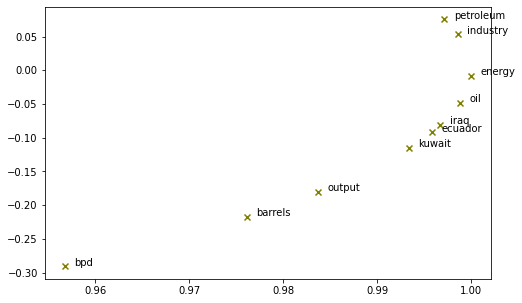

In [29]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>

---

Two related clusters emerge: **the oil-exporting couties** and the oil-related words.

"iraq", "ecuador" and "kuwait" are closely related as they are the country name, specifically the major oil exporting nations.

"petroleum", "energy", and "oil" is another closely related topic, as it involves around environmental exsahusible resources for consumption. "industry" is also clusterd here as this word often take place with "energy" and/ or "oil".


For words that should have been closer to the oil-related clusters, "bpd" and "barrel" are the units for oil products, thus should be staying closer to "oil". But it turns out some neutral, generic word like "output" is closer.


---





## Part 2: Prediction-Based Word Vectors (13 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [30]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            word_vectors: All 400000 embeddings, each lengh 100
    """
    import gensim.downloader as api
    word_vectors = api.load("glove-wiki-gigaword-300")
    # print("Loaded vocab size %i" % len(word_vectors))
    return word_vectors

In [31]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [32]:
word_vectors

In [33]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
# word_vectors = load_embedding_model()
# type(word_vectors)

In [34]:
# try some function most_similar
word_vectors.most_similar('queen')

[('elizabeth', 0.6771447658538818),
 ('princess', 0.635676383972168),
 ('king', 0.6336469650268555),
 ('monarch', 0.5814188122749329),
 ('royal', 0.543052613735199),
 ('majesty', 0.5350357294082642),
 ('victoria', 0.5239557027816772),
 ('throne', 0.5097099542617798),
 ('lady', 0.5045416355133057),
 ('crown', 0.49980056285858154)]

#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:




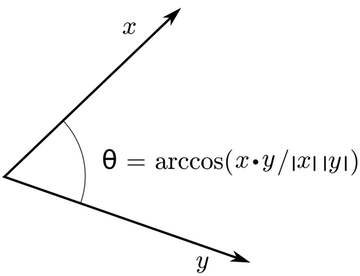

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.1: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `word_vectors.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [35]:
# ------------------
# Write your implementation here.

word_vectors.most_similar('book')
# ------------------

[('books', 0.7986249327659607),
 ('author', 0.7123498916625977),
 ('published', 0.6973031759262085),
 ('novel', 0.6966710686683655),
 ('memoir', 0.6465641260147095),
 ('wrote', 0.631791889667511),
 ('biography', 0.6225202083587646),
 ('autobiography', 0.603348970413208),
 ('essay', 0.5995662212371826),
 ('illustrated', 0.5914922952651978)]

In [36]:
word_vectors.most_similar('free')

[('freedom', 0.4974668025970459),
 ('without', 0.48699691891670227),
 ('available', 0.48415109515190125),
 ('allowed', 0.4798740744590759),
 ('give', 0.4775182008743286),
 ('access', 0.47569626569747925),
 ('unrestricted', 0.4755344092845917),
 ('go', 0.47410497069358826),
 ('allow', 0.473043829202652),
 ('all', 0.47048091888427734)]

In [37]:
word_vectors.most_similar('kind')

[('sort', 0.9157270789146423),
 ('thing', 0.8076795339584351),
 ('something', 0.8019971251487732),
 ('really', 0.7703935503959656),
 ('think', 0.7361322641372681),
 ('what', 0.7342531681060791),
 ('nothing', 0.7274984121322632),
 ('anything', 0.7253236174583435),
 ('you', 0.7192934155464172),
 ('certainly', 0.7054327726364136)]

In [38]:
word_vectors.most_similar('bright')

[('colors', 0.6087764501571655),
 ('blue', 0.595706582069397),
 ('yellow', 0.5886391401290894),
 ('dark', 0.5874146223068237),
 ('colored', 0.5830612778663635),
 ('brightly', 0.5787879824638367),
 ('brighter', 0.5764387845993042),
 ('light', 0.5631998777389526),
 ('shiny', 0.548277735710144),
 ('glow', 0.5474361181259155)]

In [39]:
word_vectors.most_similar('train')

[('trains', 0.823096513748169),
 ('bus', 0.670767068862915),
 ('rail', 0.635927140712738),
 ('commuter', 0.5964051485061646),
 ('freight', 0.5893657803535461),
 ('passenger', 0.5863174200057983),
 ('railway', 0.5833747982978821),
 ('buses', 0.5471792221069336),
 ('subway', 0.5458870530128479),
 ('passengers', 0.5390786528587341)]

In [40]:
word_vectors.most_similar('let')

[('want', 0.7677186727523804),
 ('you', 0.755077600479126),
 ("'ll", 0.7326532006263733),
 ('letting', 0.7323309779167175),
 ('go', 0.7310500741004944),
 ("n't", 0.7278926968574524),
 ('do', 0.7209917902946472),
 ('ca', 0.7142171263694763),
 ('tell', 0.7063310146331787),
 ('ask', 0.700111448764801)]

In [41]:
word_vectors.most_similar('flat')

[('lower', 0.47144830226898193),
 ('thin', 0.4606584906578064),
 ('steep', 0.44942817091941833),
 ('bottom', 0.4260002374649048),
 ('prices', 0.4257771968841553),
 ('relatively', 0.4247564673423767),
 ('slightly', 0.42393964529037476),
 ('fairly', 0.40919122099876404),
 ('plain', 0.40724343061447144),
 ('falling', 0.4068793058395386)]

#### <font color="red">Write your answer here.</font>

Most of the polysemes and hypernyms used above seems to have failed to capture its additional or secondary meaning.

For example, the word "book", when searched for 10 most similar words, the results are mostly about the materials related to knowledges, which is the primary meaning of such word. But the alternative meaning of "book" as verb, as in booking a hotel room or making reservation, is entirely overlooked.

The same phenomenon where the primary meaning also reflects in 10 most reflected words are 'train' and 'flat'.


As for train, the related words captures the primary use of a word as locomotive vehicles, not the verb as in 'train the muscles, train your mind, etc. Also, in "flate" where the adjective meaning is shown, without the other meaning as accomodotation, as in "he lives in a flat".

---



### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `word_vectors.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [42]:
# ------------------
# Write your implementation here.

w1 = 'black'
w2 = 'dark'
w3 = 'white'
print(f"The distance between synonym words {w1}, {w2}: {word_vectors.distance(w1, w2)}")
print(f"The distance between antonyms words {w1}, {w3}: {word_vectors.distance(w1, w3)}")

# ------------------

The distance between synonym words black, dark: 0.4207456707954407
The distance between antonyms words black, white: 0.2864179015159607


From thie above example, it shows that the distace between antonyms is smaller than that of synonym, meaning they are more related to one another!

#### <font color="red">Write your answer here.</font>


The plausible explanation for such counterintuitive finding that antonyms are more closely related than synonyms is the frequency they appear together. Synonyms, though sharing the mutual semantics, may not occur adjacent to another synonyms, as it would lead to redundancy. On the other hand, opposite words may be place close to each other, for stark comparison between two things, making the algorithm understand that these antonyms are more interrelated.




.

---


### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [43]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(word_vectors.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6713277101516724),
 ('princess', 0.5432624220848083),
 ('throne', 0.5386104583740234),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.498025119304657),
 ('mother', 0.4956442713737488),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747087478637695),
 ('prince', 0.4668239951133728),
 ('wife', 0.4647327661514282)]


### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top).

**Note**: You may have to try many analogies to find one that works!

In [44]:
# ------------------
# Write your implementation here.


word_vectors.most_similar(positive=['woman', 'male'], negative=['man'])
# ------------------

[('female', 0.8488893508911133),
 ('women', 0.5879524946212769),
 ('males', 0.5201805830001831),
 ('females', 0.5195831656455994),
 ('pregnant', 0.5157788991928101),
 ('adult', 0.4962882995605469),
 ('sex', 0.48539209365844727),
 ('girls', 0.46756434440612793),
 ('gender', 0.45728668570518494),
 ('sexual', 0.44429826736450195)]

In [45]:
word_vectors.most_similar(positive=['daughter', 'boy'], negative=['son'])

[('girl', 0.887003481388092),
 ('girls', 0.6548776030540466),
 ('mother', 0.6525065302848816),
 ('woman', 0.6493716239929199),
 ('child', 0.6013819575309753),
 ('grandmother', 0.5976220965385437),
 ('teenager', 0.589718222618103),
 ('teenage', 0.5784621238708496),
 ('boys', 0.5780875086784363),
 ('girlfriend', 0.5757790803909302)]

In [46]:
word_vectors.most_similar(positive=['sky', 'green'], negative=['trees'])

[('blue', 0.5512756109237671),
 ('bright', 0.45733803510665894),
 ('dark', 0.44471269845962524),
 ('red', 0.4309699535369873),
 ('purple', 0.42887037992477417),
 ('brown', 0.41242167353630066),
 ('yellow', 0.3855505585670471),
 ('black', 0.3697638511657715),
 ('skies', 0.3605387806892395),
 ('colour', 0.3567811846733093)]

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors.

In [47]:
# ------------------
# Write your implementation here.

word_vectors.most_similar(positive=['tv', 'read'], negative=['book'])


# ------------------

[('television', 0.7062621116638184),
 ('broadcast', 0.6143285632133484),
 ('broadcasts', 0.5504031181335449),
 ('radio', 0.5457763671875),
 ('channel', 0.5182363986968994),
 ('watch', 0.5027680397033691),
 ('watching', 0.501125693321228),
 ('viewers', 0.48809871077537537),
 ('cnn', 0.48373645544052124),
 ('cable', 0.48029640316963196)]

In [48]:
word_vectors.most_similar(positive=['yellow', 'apple'], negative=['red'])

[('iphone', 0.49975669384002686),
 ('ipad', 0.4942600727081299),
 ('ipod', 0.49260827898979187),
 ('macintosh', 0.4613226652145386),
 ('google', 0.45330381393432617),
 ('microsoft', 0.43000563979148865),
 ('intel', 0.42604002356529236),
 ('imac', 0.41385483741760254),
 ('ibm', 0.3970990777015686),
 ('motorola', 0.3851204514503479)]

In [49]:
word_vectors.most_similar(positive=['red', 'banana'], negative=['yellow'])

[('bananas', 0.5103011131286621),
 ('mango', 0.4726327359676361),
 ('coffee', 0.4201294183731079),
 ('strawberry', 0.4139113128185272),
 ('fruit', 0.4084935784339905),
 ('sugar', 0.40686509013175964),
 ('papaya', 0.40092340111732483),
 ('growers', 0.3974452018737793),
 ('coconut', 0.39661210775375366),
 ('pineapple', 0.39483538269996643)]

In [50]:
word_vectors.most_similar(positive=['morning', 'sleep'], negative=['night'])

[('asleep', 0.513579249382019),
 ('sleeping', 0.5048273801803589),
 ('woke', 0.4851740300655365),
 ('slept', 0.45095255970954895),
 ('bed', 0.44980132579803467),
 ('nap', 0.4347187280654907),
 ('awake', 0.42049551010131836),
 ('waking', 0.4183635115623474),
 ('awoke', 0.395452618598938),
 ('a.m.', 0.3887363076210022)]

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [51]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(word_vectors.most_similar(positive=['woman', 'worker'], negative=['man']))
pprint.pprint(word_vectors.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.5915157794952393),
 ('workers', 0.5560789108276367),
 ('nurse', 0.514857828617096),
 ('pregnant', 0.4897522032260895),
 ('mother', 0.48388367891311646),
 ('female', 0.46243947744369507),
 ('child', 0.4448588490486145),
 ('teacher', 0.44152435660362244),
 ('waitress', 0.44121503829956055),
 ('employer', 0.4378713071346283)]
[('workers', 0.5640615224838257),
 ('employee', 0.5365462303161621),
 ('laborer', 0.483084499835968),
 ('working', 0.474678635597229),
 ('factory', 0.4493158459663391),
 ('mechanic', 0.43802663683891296),
 ('work', 0.4276600480079651),
 ('unemployed', 0.42742660641670227),
 ('worked', 0.4222966134548187),
 ('job', 0.42074185609817505)]


#### <font color="red">Write your answer here.</font>

(a) which terms are most similar to "woman" and "worker" and most dissimilar to "man"


The result shows the stereotypical mentality about women in professional setting. Word related to woman in jobs involves around motherly nature such as 'nurse', 'teacher' and 'waitress', and also 'pregnant'.


(b) which terms are most similar to "man" and "worker" and most dissimilar to "woman"


A stereotype of physical strenghts used in job reflects throught the (b) as the list contains such as 'laborer', 'mechanic' and 'factory'. Some negative biase toward lazinesso of man is also captured as in the word 'unemployed'.



.
---

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [52]:
# ------------------
# Write your implementation here.

pprint.pprint(word_vectors.most_similar(positive=['female', 'food'], negative=['male']))
pprint.pprint(word_vectors.most_similar(positive=['male', 'food'], negative=['female']))
# ------------------

[('foods', 0.6103315353393555),
 ('supplies', 0.5462762117385864),
 ('products', 0.5149519443511963),
 ('meals', 0.511093258857727),
 ('shortages', 0.5021740198135376),
 ('aid', 0.4981635808944702),
 ('vegetables', 0.49693071842193604),
 ('eat', 0.49676570296287537),
 ('nutrition', 0.4899175763130188),
 ('meat', 0.48773324489593506)]
[('foods', 0.6060277223587036),
 ('eat', 0.5761719346046448),
 ('supplies', 0.5565237998962402),
 ('eating', 0.5500626564025879),
 ('meat', 0.5441587567329407),
 ('meal', 0.5331789255142212),
 ('meals', 0.5195803642272949),
 ('supply', 0.5031853318214417),
 ('feed', 0.4982718229293823),
 ('medicines', 0.4943087100982666)]


In [53]:
# ------------------
# Write your implementation here.

pprint.pprint(word_vectors.most_similar(positive=['son', 'education'], negative=['daughter']))
pprint.pprint(word_vectors.most_similar(positive=['daughter', 'education'], negative=['son']))
# ------------------

[('educational', 0.6169756054878235),
 ('schools', 0.5731616020202637),
 ('health', 0.5516809225082397),
 ('teaching', 0.5405141711235046),
 ('curriculum', 0.537800133228302),
 ('school', 0.5329912900924683),
 ('vocational', 0.5234990119934082),
 ('programs', 0.509280800819397),
 ('teachers', 0.503345787525177),
 ('students', 0.49978548288345337)]
[('educational', 0.6250971555709839),
 ('schools', 0.570708692073822),
 ('teaching', 0.54721999168396),
 ('curriculum', 0.5404050946235657),
 ('teacher', 0.5312469005584717),
 ('school', 0.5282274484634399),
 ('health', 0.5276145339012146),
 ('programs', 0.5196062326431274),
 ('students', 0.5155026912689209),
 ('social', 0.5053571462631226)]


#### <font color="red">Write your answer here.</font>


The first example of gender and food shows the bias about how women and men are supposed to eat. In words related to women, we see words like "vegetables", and  "nutrituion" to suggest the bias that women should take care of their food regime, while for men-related words about food, we have "meat" instead to suggest that men are more carnivorous.

The second example shows the bias of educational choices based on gender. For "son", the more technical fields are more related as we have "vocational" listed, contrary to the "daughters" that has "social" implying that women are more generally exposed to less marketable fields.

.

---


### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. Argue whether this can be lead to problems into the society.  Last, how do we address this.

#### <font color="red">Write your answer here.</font>


The word vectors that we are implemented has been trained on the expansive amount of real world datasets such as from newspaper or social media. The bias simply reflects how the society percieve the characteristics of each topic that has been circulated through comments, articles, journal. etc.

These stereotypical idea, conveyed through coocurrence of words, is the source of model training, thus keeping the bias in its word vectors. Solutions about bias is a challenging topic, if not impossible to settle, as it involves the value, beliefe and perception that has been embedded  at both personal, organizaitonal, national and even global levels.

One thing we can do about the bias, however, is to practice critical thinking. Bias or stereotype may give the general idea of how such things are percieved by the external parties, but it is not necessarily the universal truth that reflects the individual virtues.